# Descriptive statistics

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('..'))
from utils import setup_spreadr

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr' + os.path.split(os.path.abspath(os.path.curdir))[1][9:]
setup_spreadr(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_2


Imports for the analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.metrics import edit_distance
import numpy as np
from pandas import DataFrame
import seaborn as sb
from django.db.models import Count

from gists.models import (Sentence, Profile, GistsConfiguration,
                          JOB_TYPE_CHOICES, EDUCATION_LEVEL_CHOICES)

from utils import memoized

config = GistsConfiguration.get_solo()

Equip models with useful tools

In [4]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

## 2 Despamming

Compute spam rate

In [5]:
spam_rate = 1 - (Sentence.objects.ham.count() / Sentence.objects.count())
print('Spam represents {:.1f}% of the sentences'.format(spam_rate * 100))

Spam represents 0.8% of the sentences


In [6]:
dropped_rate = 1 - (Sentence.objects.kept.count() / Sentence.objects.count())
print('Spam+rogues represents {:.1f}% of the sentences'.format(dropped_rate * 100))

Spam+rogues represents 0.9% of the sentences


This is 😀

## 3 Interaction of profile variables

Compute the variables

In [7]:
profiles = profiles = Profile.objects\
    .annotate(Count('sentences'))\
    .filter(sentences__count=config.experiment_work + config.training_work,
            user__is_staff=False)
data = []
job_type_map = dict(JOB_TYPE_CHOICES)
education_level_map = dict(EDUCATION_LEVEL_CHOICES)
print('Computing variables on {} profiles...'.format(len(profiles)), end='')
for profile in profiles:
    print(' #{}'.format(profile.id), end='')
    try:
        ed_level_id = int(profile.questionnaire.education_level)
    except ValueError:
        ed_level_id = np.NaN
    data.append({
        'raw TR': profile.transformation_rate('raw'),
        'ordered content TR': profile.transformation_rate('ordered_content'),
        'age': profile.questionnaire.age,
        'gender': profile.questionnaire.gender,
        'job type': job_type_map[profile.questionnaire.job_type],
        'ed level': education_level_map[profile.questionnaire.education_level],
        'ed level id': ed_level_id,
    })

profiles_interactions = DataFrame(data, index=[p.id for p in profiles])

Computing variables on 49 profiles... #2 #3 #4 #5 #6 #7 #8 #9 #10 #11 #12 #13 #14 #15 #16 #17 #18 #19 #21 #22 #23 #24 #25 #26 #27 #28 #29 #30 #32 #33 #34 #35 #36 #37 #38 #39 #40 #41 #42 #43 #44 #45 #46 #47 #48 #49 #50 #51 #52

And plot them, first with gender as color (**not much to say to these graphs**):

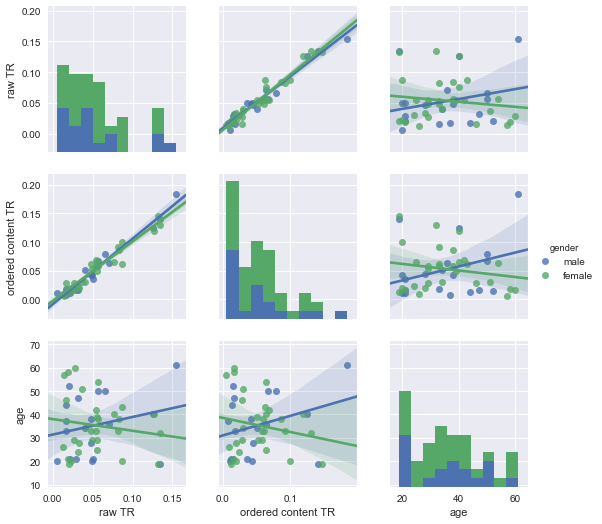

In [8]:
sb.pairplot(profiles_interactions, hue='gender',
            vars=['raw TR',
                  'ordered content TR',
                  'age'],
            kind='reg');

Then with job type as color (**not much to say to this either**):

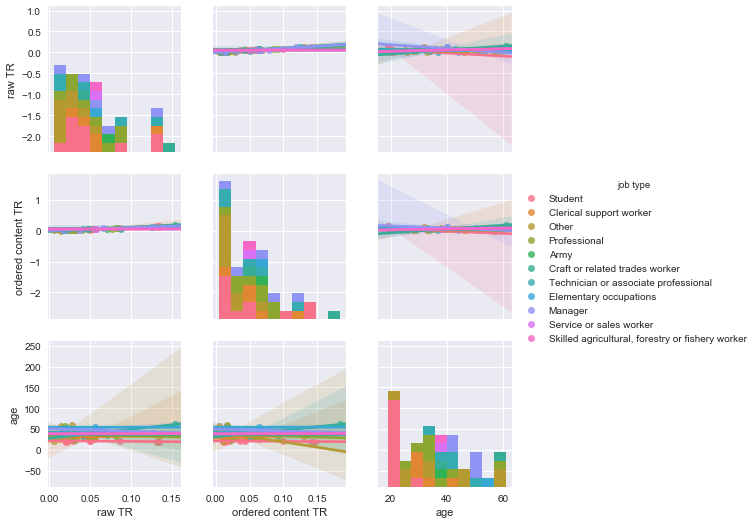

In [9]:
sb.pairplot(profiles_interactions, hue='job type',
            vars=['raw TR',
                  'ordered content TR',
                  'age'],
            kind='reg');

Then with education level as color (**not much to say to this either**):

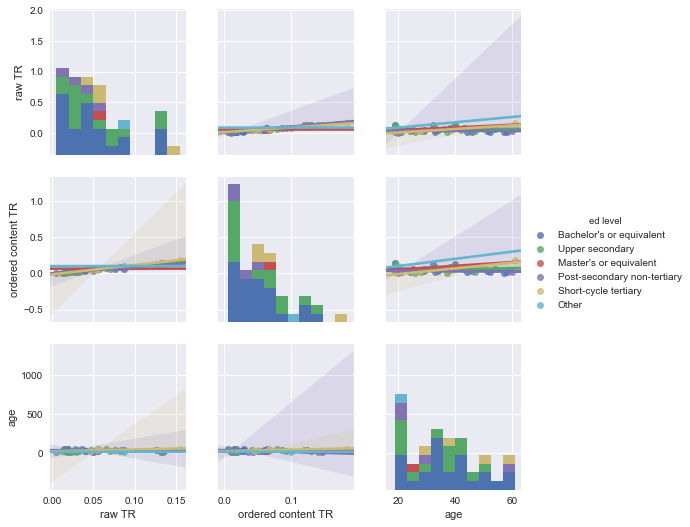

In [10]:
sb.pairplot(profiles_interactions, hue='ed level',
            vars=['raw TR',
                  'ordered content TR',
                  'age'],
            kind='reg');

A boxplot of the interaction between gender, job type, and transformation rate (**again, not much to say to this**):

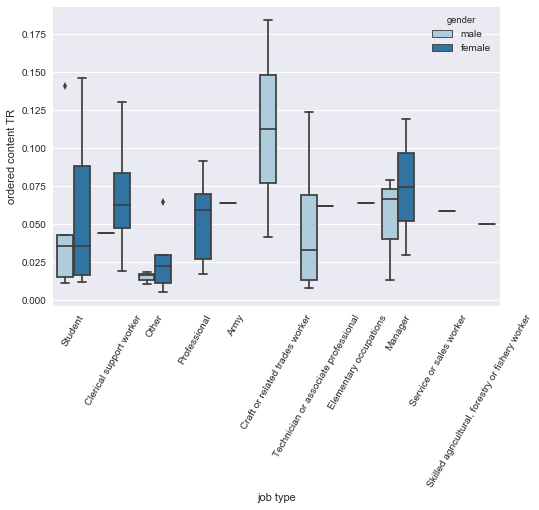

In [11]:
ax = sb.boxplot(data=profiles_interactions, x='job type', y='ordered content TR',
                hue='gender', palette='Paired')
ax.set_xticklabels([t.get_text() for t in ax.get_xticklabels()], rotation=60);

And another boxplot of the interaction between gender, education level, and transformation rate (**again, not much to say to this**):

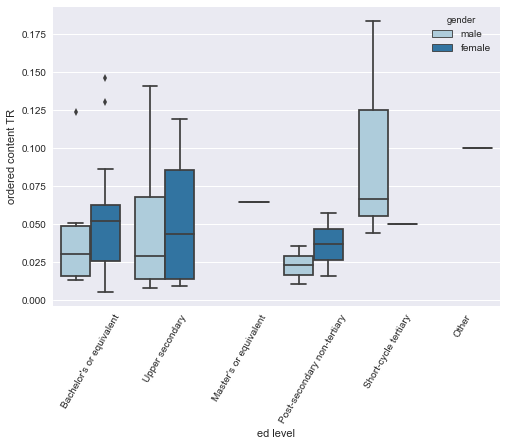

In [12]:
ax = sb.boxplot(data=profiles_interactions, x='ed level', y='ordered content TR',
                hue='gender', palette='Paired')
ax.set_xticklabels([t.get_text() for t in ax.get_xticklabels()], rotation=60);

Interaction of education level and transformation rate?

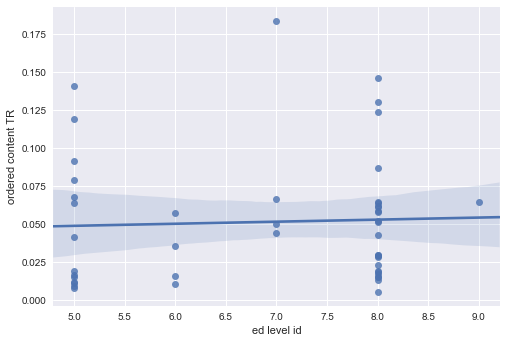

In [13]:
sb.regplot(data=profiles_interactions, x='ed level id', y='ordered content TR')

... none.

Age?

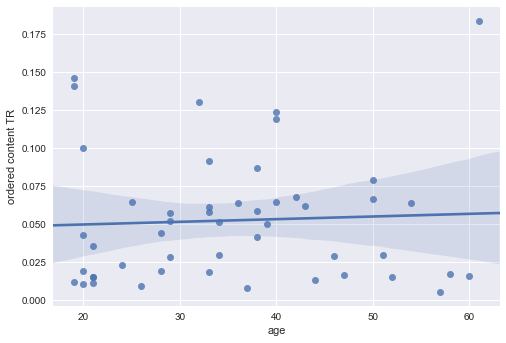

In [14]:
sb.regplot(data=profiles_interactions, x='age', y='ordered content TR')

Nope. Or very slight, getting better (lower TR) with age!